In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import getpass
%matplotlib inline

In [3]:
pw = getpass.getpass()
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=pw,
                       db="olist");

········


In [4]:
q = """
    SELECT DISTINCT
        DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS month_id,
        oi.seller_id
    FROM orders o
        JOIN order_items oi
        ON o.order_id = oi.order_id
    ORDER BY 1,2
"""

df = pd.read_sql(q, conn)

In [5]:
df.head()

,month_id,seller_id
0,2016-09-01,1554a68530182680ad5c8b042c3ab563
1,2016-09-01,a425f92c199eb576938df686728acd20
2,2016-09-01,ecccfa2bb93b34a3bf033cc5d1dcdc69
3,2016-10-01,011b0eaba87386a2ae96a7d32bb531d1
4,2016-10-01,01cf7e3d21494c41fb86034f2e714fa1


In [6]:
df["month_id"] = pd.to_datetime(df["month_id"])

In [7]:
df["month_id"].max()

Timestamp('2018-09-01 00:00:00')

In [8]:
df

,month_id,seller_id
0,2016-09-01,1554a68530182680ad5c8b042c3ab563
1,2016-09-01,a425f92c199eb576938df686728acd20
2,2016-09-01,ecccfa2bb93b34a3bf033cc5d1dcdc69
3,2016-10-01,011b0eaba87386a2ae96a7d32bb531d1
4,2016-10-01,01cf7e3d21494c41fb86034f2e714fa1
...,...,...
16436,2018-08-01,ffa6adafb71b807dc13159e26431354c
16437,2018-08-01,ffc470761de7d0232558ba5e786e57b7
16438,2018-08-01,ffdd9f82b9a447f6f8d4b91554cc7dd3
16439,2018-08-01,fffd5413c0700ac820c7069d66d98c89


In [9]:
df_shifted = df.assign(shifted_month=df["month_id"] + pd.DateOffset(months=1))

In [10]:
df_shifted = df_shifted[df["month_id"] < df["month_id"].max()]

In [11]:
first_sale = (df
              .groupby("seller_id")
              .min()[["month_id"]]
              .reset_index()
              .rename(columns={"month_id": "first_sale_month"}))

In [12]:
df = df.merge(first_sale, how="left", left_on=["month_id", "seller_id"], right_on=["first_sale_month", "seller_id"])

In [13]:
df = df.merge(df_shifted, how="outer", left_on=["month_id", "seller_id"], right_on=["shifted_month", "seller_id"])

In [14]:
df["month_id"] = df["month_id_x"].combine_first(df["shifted_month"])

In [15]:
df = (df
      .assign(churned=df["month_id_x"].isnull().astype(int))
      .assign(new=np.where(~df["first_sale_month"].isnull(), 1, 0))
      .assign(repeat=np.where((df["month_id_x"] == df["shifted_month"]), 1, 0)))

df = df.assign(returning=np.where(df["churned"] + df["new"] + df["repeat"] == 0, 1, 0))

In [35]:
df = df.assign(growth=df[["new", "repeat", "returning", "churned"]].idxmax(1))

In [38]:
df = df[["month_id", "seller_id", "growth"]]

In [41]:
df_g = df.groupby(["month_id", "growth"]).count().reset_index()

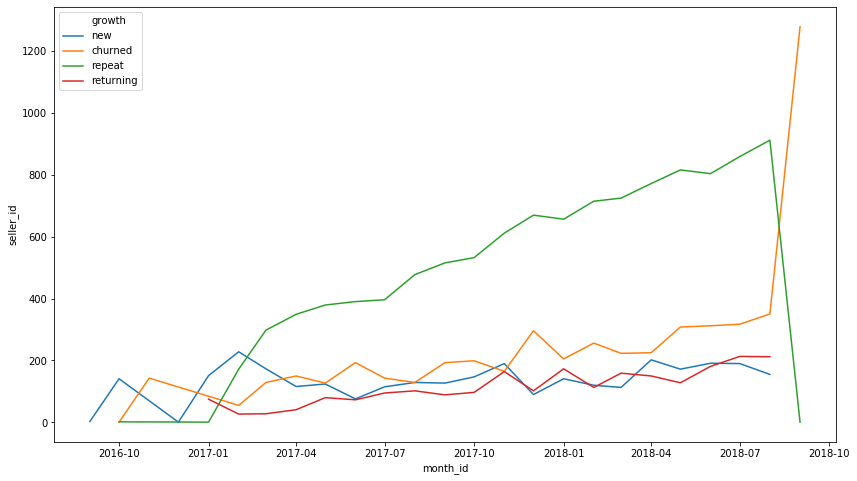

In [47]:
fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(data=df_g,
             x="month_id",
             y="seller_id",
             hue="growth",
             ax=ax);